*<center><h1 style="color:black;background-color:white; padding:10px; border-radius:10px;">California Housing Price Prediction - Advanced Analysis</h1></center>*

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import RFECV, RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore') # 
import scipy.stats as stats # Provides statistical functions and tests (e.g., t-tests, chi-square, correlation tests)


## 1. Data Preparation

In [3]:
# Load the datasetfrom sklearn.datasets 
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing(as_frame=True)
df = california.data
df['PRICE'] = california.target

In [4]:
# Initial inspection
print(f"Dataset shape: {df.shape}")
print("\nFeature descriptions:")
for i, feature in enumerate(california.feature_names):
    print(f"- {feature}: {california.DESCR.split('- ' + feature)[1].split('\\n')[0]}")
print(f"- PRICE: Median house value in $100,000s")

print("\nFirst 5 rows:")
display(df.head())


Dataset shape: (20640, 9)

Feature descriptions:
- MedInc:         median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bureau publishes sample data (a block group typically has a population
of 600 to 3,000 people).

A househ

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## 2. Exploratory Data Analysis

In [5]:
# Basic statistics
print("\nBasic statistics for all features:")
display(df.describe())


Basic statistics for all features:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


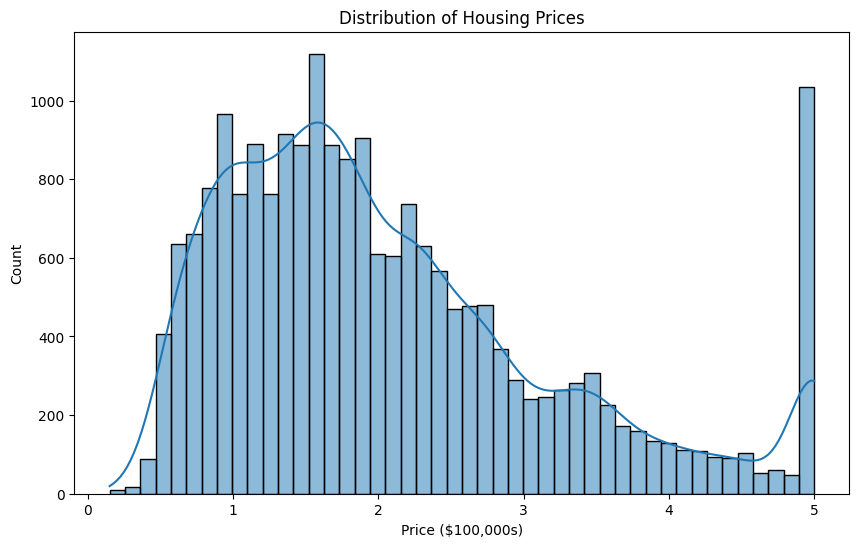

In [6]:
# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['PRICE'], kde=True)
plt.title('Distribution of Housing Prices')
plt.xlabel('Price ($100,000s)')
plt.show()

In [7]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)


Missing values in each column:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
PRICE         0
dtype: int64


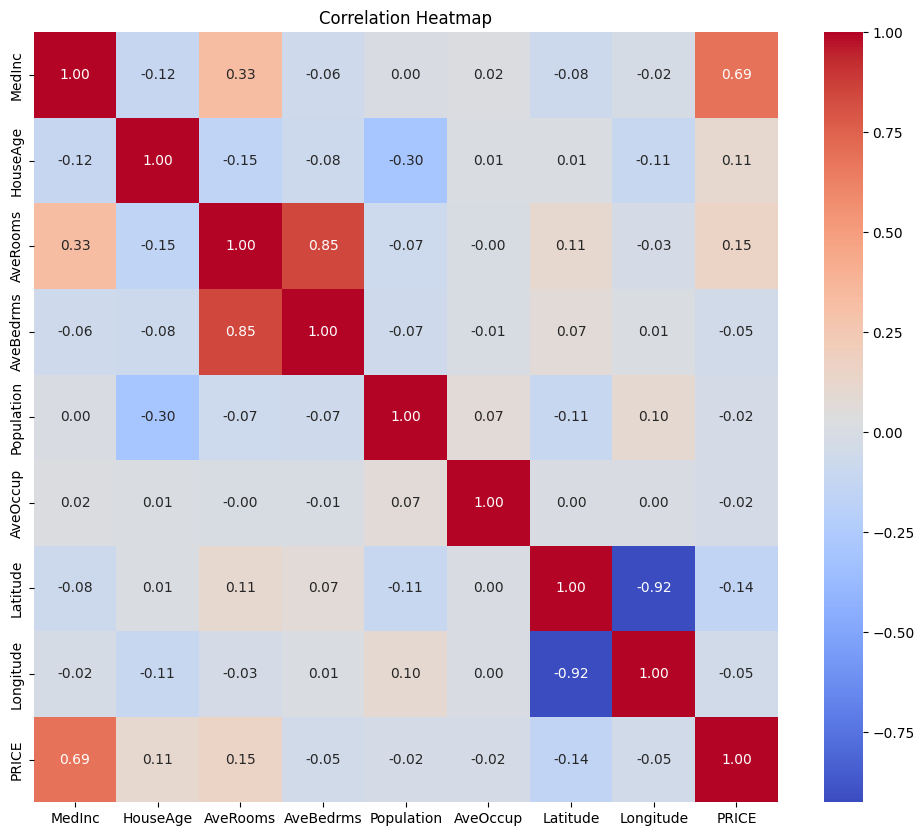

In [8]:
# Correlation analysis
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [9]:
# Correlation with target
price_corr = corr_matrix['PRICE'].sort_values(ascending=False)
print("\nCorrelation with target variable (PRICE):")
print(price_corr)


Correlation with target variable (PRICE):
PRICE         1.000000
MedInc        0.688075
AveRooms      0.151948
HouseAge      0.105623
AveOccup     -0.023737
Population   -0.024650
Longitude    -0.045967
AveBedrms    -0.046701
Latitude     -0.144160
Name: PRICE, dtype: float64


<Figure size 1600x1200 with 0 Axes>

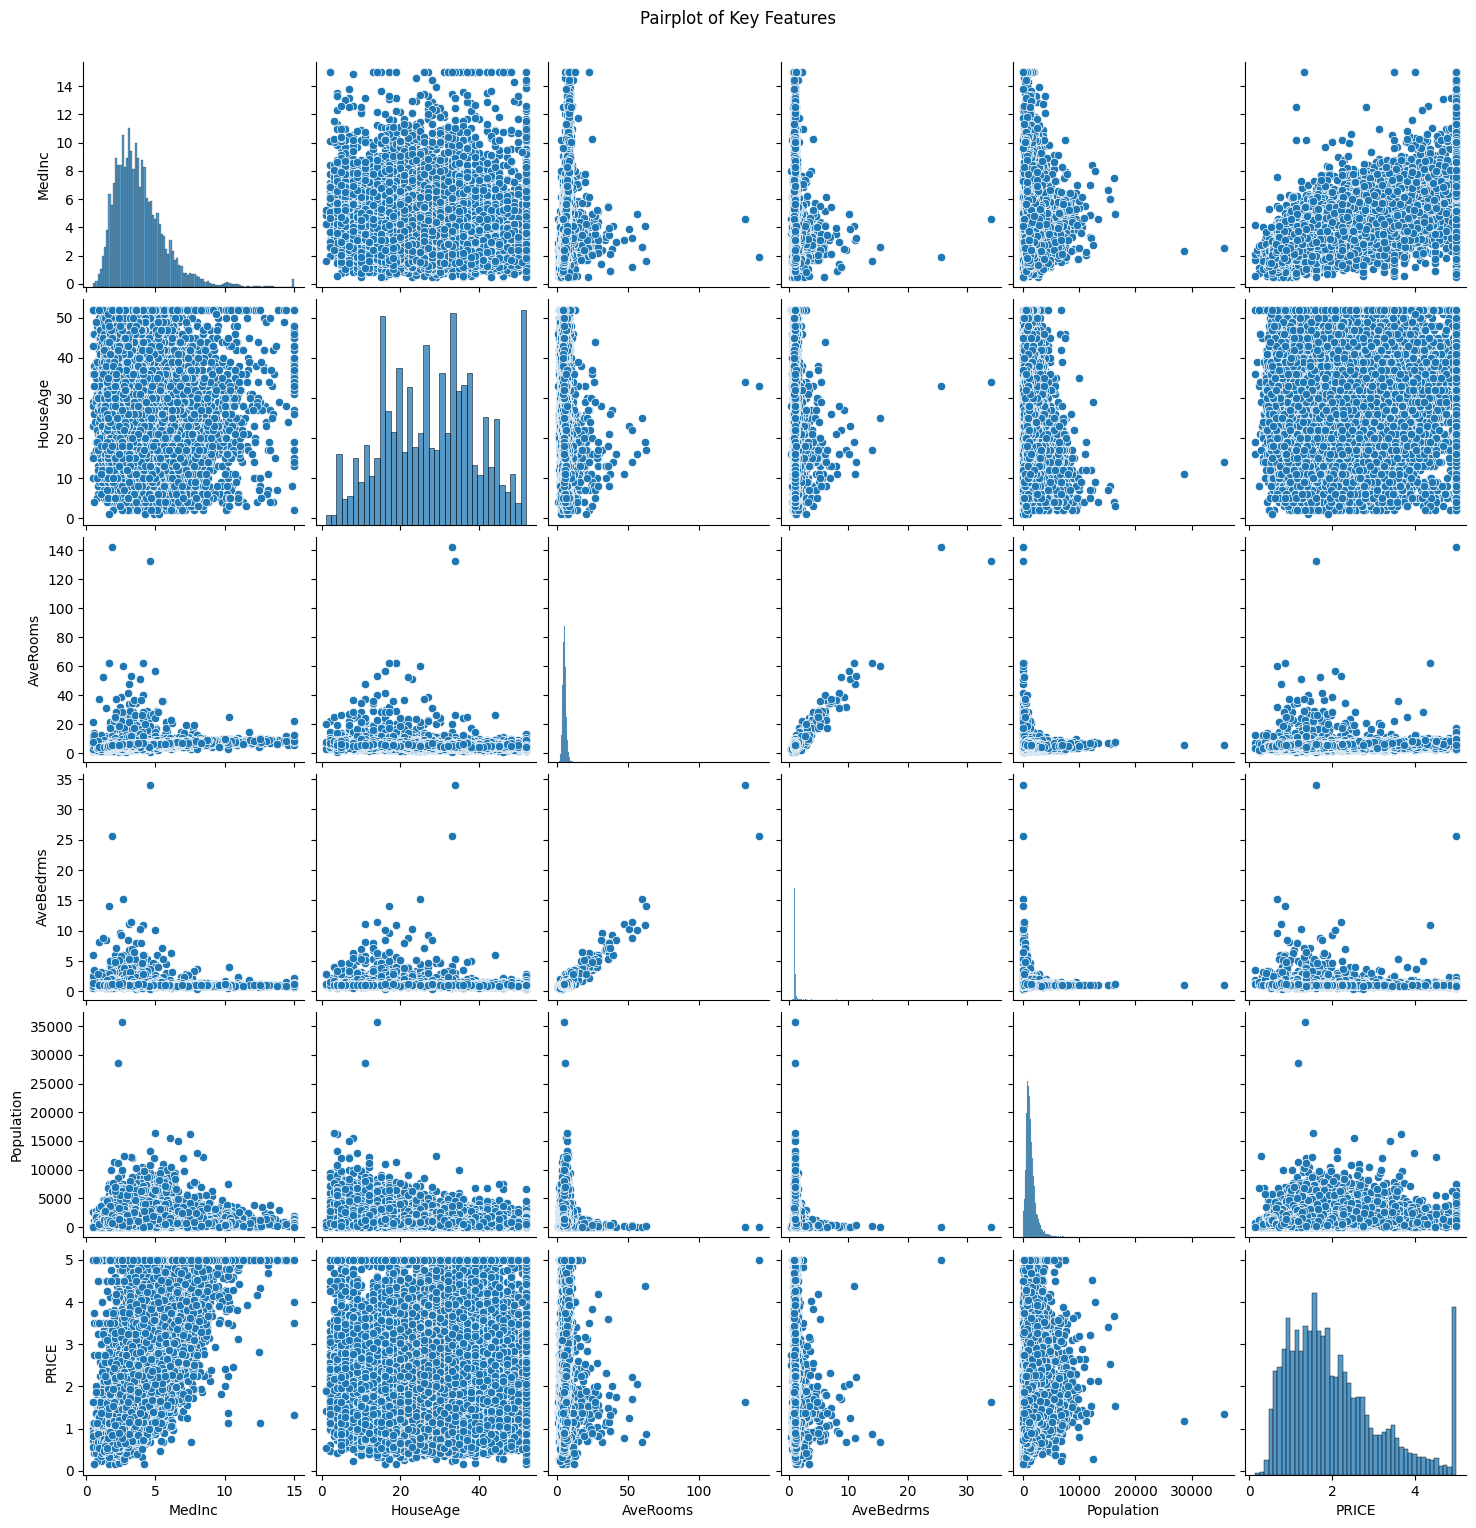

In [10]:
# Pairplots for key features
plt.figure(figsize=(16, 12))
sns.pairplot(df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'PRICE']])
plt.suptitle('Pairplot of Key Features', y=1.02)
plt.show()

## 3. Multicollinearity Check

In [11]:
# Function to calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values("VIF", ascending=False)


In [12]:
# Select numerical features for VIF calculation (all features in this dataset are numerical)
X_vif = df.drop('PRICE', axis=1)


In [13]:
# Check for high correlation features before VIF
high_corr_pairs = []
for i in range(len(X_vif.columns)):
    for j in range(i+1, len(X_vif.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr_pairs:
    print("High correlation pairs (>0.7):")
    for pair in high_corr_pairs:
        print(f"{pair[0]} and {pair[1]}: {pair[2]:.4f}")
else:
    print("No feature pairs with correlation > 0.7 found.")

High correlation pairs (>0.7):
AveRooms and AveBedrms: 0.8476
Latitude and Longitude: -0.9247


In [14]:
# Calculate VIF for features
vif_df = calculate_vif(X_vif)
print("\nVariance Inflation Factors:")
print(vif_df)



Variance Inflation Factors:
      Feature         VIF
7   Longitude  633.711654
6    Latitude  559.874071
2    AveRooms   45.993601
3   AveBedrms   43.590314
0      MedInc   11.511140
1    HouseAge    7.195917
4  Population    2.935745
5    AveOccup    1.095243


In [15]:
# Identify features with high VIF (>5)
high_vif_features = vif_df[vif_df["VIF"] > 5]["Feature"].tolist()
if high_vif_features:
    print(f"\nFeatures with high multicollinearity (VIF > 5): {high_vif_features}")
    print("Consider removing or transforming these features.")
else:
    print("\nNo severe multicollinearity detected.")



Features with high multicollinearity (VIF > 5): ['Longitude', 'Latitude', 'AveRooms', 'AveBedrms', 'MedInc', 'HouseAge']
Consider removing or transforming these features.


## 4. Outlier Detection

In [16]:
# Function to detect outliers using IQR method
def detect_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers, lower_bound, upper_bound


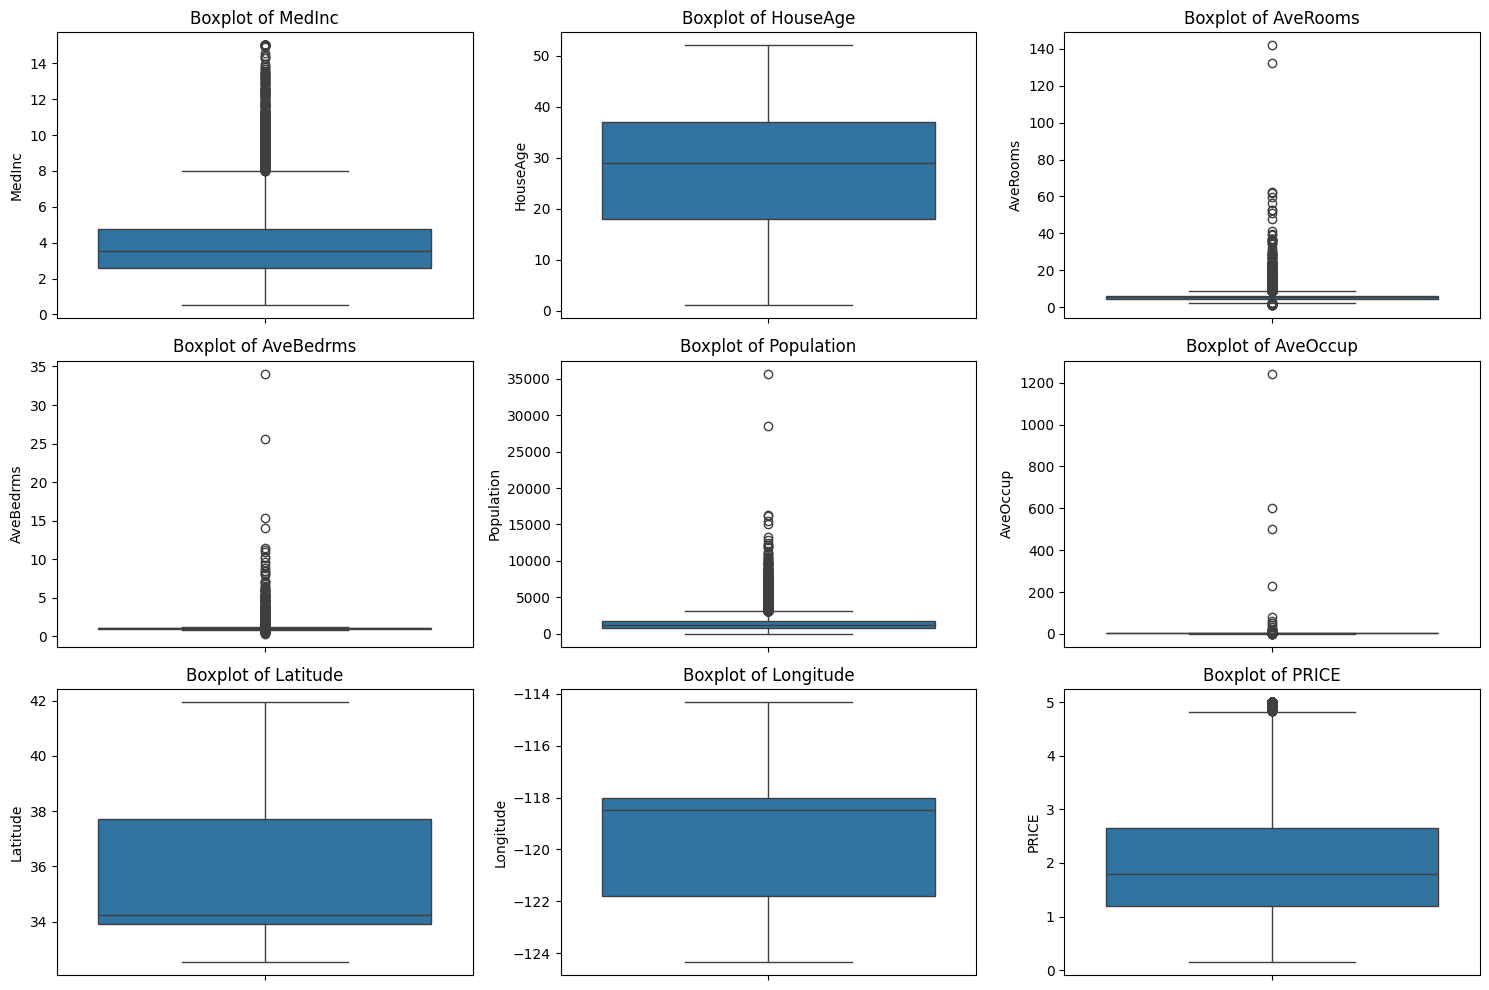

In [17]:
# Plot boxplots to visualize outliers in all columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.show()


In [18]:
# Detect outliers in all features
outliers_summary = {}
for col in df.columns:
    outliers, lower, upper = detect_outliers_iqr(df, col)
    if not outliers.empty:
        outliers_summary[col] = {'count': len(outliers), 'percentage': len(outliers)/len(df)*100, 
                               'lower_bound': lower, 'upper_bound': upper}

print("\nOutlier Summary:")
for col, stats_info in outliers_summary.items():
    print(f"{col}: {stats_info['count']} outliers ({stats_info['percentage']:.2f}%)")
 


Outlier Summary:
MedInc: 681 outliers (3.30%)
AveRooms: 511 outliers (2.48%)
AveBedrms: 1424 outliers (6.90%)
Population: 1196 outliers (5.79%)
AveOccup: 711 outliers (3.44%)
PRICE: 1071 outliers (5.19%)


In [19]:
# Create a clean dataset without extreme outliers for the target variable
if 'PRICE' in outliers_summary:
    df_clean = df[(df['PRICE'] >= outliers_summary['PRICE']['lower_bound']) & 
                 (df['PRICE'] <= outliers_summary['PRICE']['upper_bound'])]
    print(f"\nRemoved {len(df) - len(df_clean)} price outliers. New shape: {df_clean.shape}")
else:
    df_clean = df.copy()
    print("\nNo outliers removed from target variable.")



Removed 1071 price outliers. New shape: (19569, 9)


## 5. Feature Engineering

In [20]:
# Create new features
df_clean['RoomPerPerson'] = df_clean['AveRooms'] / df_clean['Population']
df_clean['BedroomPerRoom'] = df_clean['AveBedrms'] / df_clean['AveRooms']
df_clean['PopulationDensity'] = df_clean['Population'] / df_clean['AveOccup']

In [21]:
# Check for and handle NaN values created during feature engineering
if df_clean.isnull().sum().sum() > 0:
    print("\nNaN values created during feature engineering:")
    print(df_clean.isnull().sum())
    df_clean = df_clean.fillna(0)  # Fill NaN with 0
    print("NaN values filled with 0")


In [22]:
# Log transform target variable to make it more normal
df_clean['PRICE_LOG'] = np.log(df_clean['PRICE'])


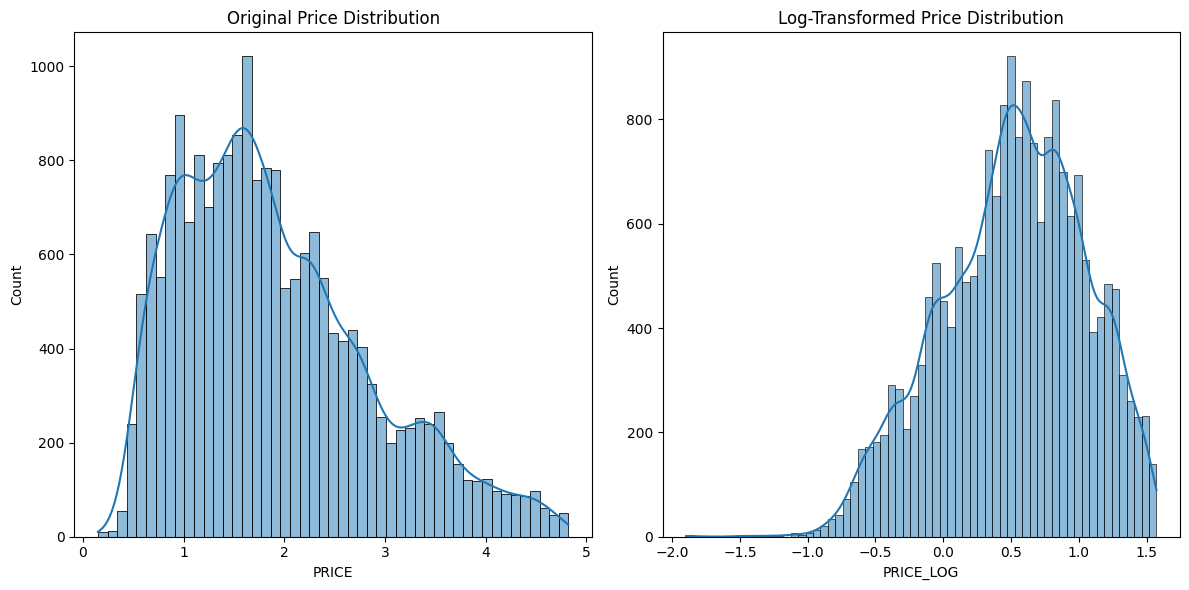

In [23]:
# Plot distribution of original and log-transformed target
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_clean['PRICE'], kde=True)
plt.title('Original Price Distribution')
plt.subplot(1, 2, 2)
sns.histplot(df_clean['PRICE_LOG'], kde=True)
plt.title('Log-Transformed Price Distribution')
plt.tight_layout()
plt.show()


## 6. Model Preparation

In [24]:
# Define features and target
X = df_clean.drop(['PRICE', 'PRICE_LOG'], axis=1)
y = df_clean['PRICE_LOG']  # Using log-transformed target

In [25]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [26]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 7. Basic Model Building

In [27]:
# Initialize and fit model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [28]:
# Coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', ascending=False)

print(coefficients)
print(f"Intercept: {lr.intercept_}")

              Feature  Coefficient
0              MedInc     0.324614
10  PopulationDensity     0.241299
2            AveRooms     0.111554
9      BedroomPerRoom     0.109664
1            HouseAge     0.045424
5            AveOccup     0.000148
8       RoomPerPerson    -0.015046
3           AveBedrms    -0.056233
4          Population    -0.211034
7           Longitude    -0.504503
6            Latitude    -0.547446
Intercept: 0.51756549449324


## 8. Basic Model Evaluation

In [29]:
# Predictions
y_pred = lr.predict(X_test_scaled)

In [30]:
# Convert predictions back from log scale
y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred)

In [31]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse_original = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
r2 = r2_score(y_test, y_pred)
r2_original = r2_score(y_test_exp, y_pred_exp)

print(f"Log scale - RMSE: {rmse}")
print(f"Log scale - R2 Score: {r2}")
print(f"Original scale - RMSE: {rmse_original}")
print(f"Original scale - R2 Score: {r2_original}")


Log scale - RMSE: 0.3147729221089915
Log scale - R2 Score: 0.6474534114488625
Original scale - RMSE: 0.6052978272321201
Original scale - R2 Score: 0.5990153796348113


In [32]:
# Cross-Validation
cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {np.mean(cv_scores)}")


Cross-validation scores: [0.61979476 0.64719575 0.64419338 0.61406337 0.63023331]
Mean CV score: 0.6310961153952436


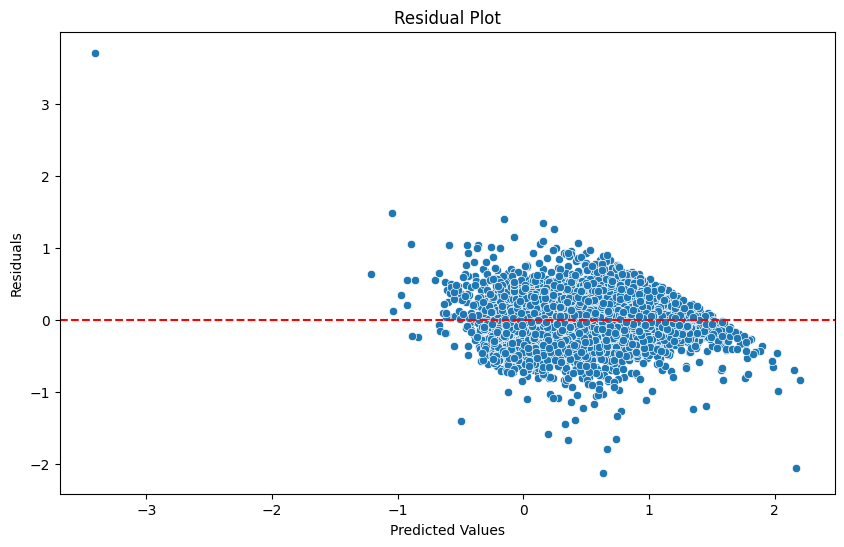

In [33]:
# Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

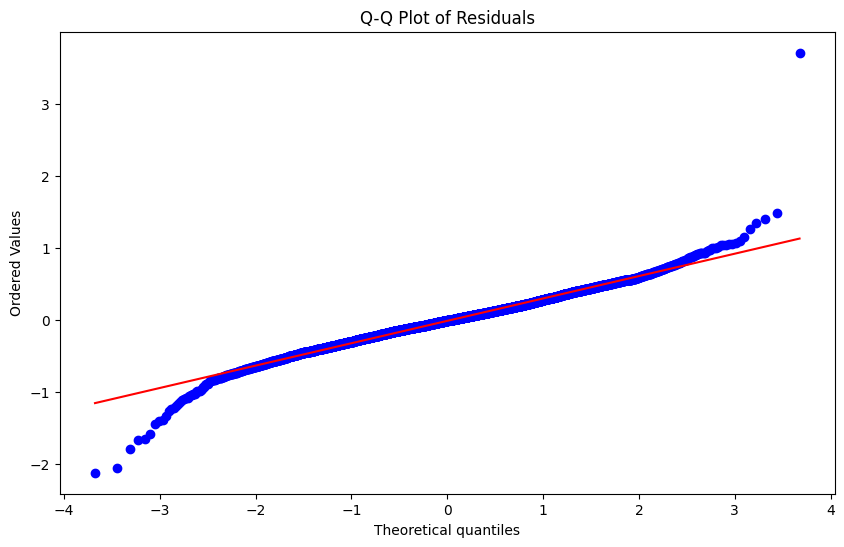

In [34]:
# Normality Check
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

## 9. Stepwise Feature Selection

In [35]:
# Using statsmodels for stepwise selection
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)


In [36]:
# Check for perfect multicollinearity
def check_collinearity(X):
    # Calculate correlation matrix
    corr = X.corr()
    # Find features with high correlation
    high_corr_vars = []
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > 0.95:  # Using 0.95 as threshold
                high_corr_vars.append((corr.columns[i], corr.columns[j]))
    return high_corr_vars

highly_correlated = check_collinearity(X_train)
if highly_correlated:
    print("Highly correlated features detected:")
    for pair in highly_correlated:
        print(f"{pair[0]} and {pair[1]}")
    
    # Remove one feature from each highly correlated pair
    features_to_remove = set([pair[1] for pair in highly_correlated])
    print(f"Removing {features_to_remove} to fix multicollinearity")
    
    # Create a copy without the problematic features
    X_train_reduced = X_train.drop(columns=features_to_remove)
    X_test_reduced = X_test.drop(columns=features_to_remove)
    
    # Add constant again
    X_train_sm = sm.add_constant(X_train_reduced)
    X_test_sm = sm.add_constant(X_test_reduced)
else:
    X_train_reduced = X_train.copy()
    X_test_reduced = X_test.copy()

try:
    # Initial model with remaining features
    model = sm.OLS(y_train, X_train_sm).fit()
    print(model.summary())
    
    # Perform backward elimination
    p_values = model.pvalues[1:]  # Skip the constant term
    
    if len(p_values) > 0:  # Make sure there are p-values to work with
        max_p_value = max(p_values)
        while max_p_value > 0.05:
            max_p_index = p_values.argmax()
            feature_to_remove = p_values.index[max_p_index]
            print(f"Removing {feature_to_remove} with p-value {max_p_value:.4f}")
            
            # Remove the feature
            X_train_sm = X_train_sm.drop(feature_to_remove, axis=1)
            
            # Refit the model
            model = sm.OLS(y_train, X_train_sm).fit()
            
            # Update p-values
            p_values = model.pvalues[1:]  # Skip the constant term
            if len(p_values) == 0:
                break
            max_p_value = max(p_values)
    
    print("\nFinal model after backward elimination:")
    print(model.summary())
    
    # Test the reduced model
    features_kept = list(X_train_sm.columns.drop('const')) if 'const' in X_train_sm.columns else list(X_train_sm.columns)
    print(f"\nFeatures kept after backward elimination: {features_kept}")
    
    X_test_reduced = X_test_reduced[features_kept]
    X_test_sm = sm.add_constant(X_test_reduced)
    
    # Predictions with reduced model
    y_pred_reduced = model.predict(X_test_sm)
    rmse_reduced = np.sqrt(mean_squared_error(y_test, y_pred_reduced))
    r2_reduced = r2_score(y_test, y_pred_reduced)
    
    print(f"\nReduced Model Performance:")
    print(f"RMSE: {rmse_reduced}")
    print(f"R2 Score: {r2_reduced}")
    
except Exception as e:
    print(f"Error fitting OLS model: {e}")
    print("Using RFE method instead of stepwise selection")
    
    # Alternative: Use RFE from scikit-learn
    selector = RFE(estimator=LinearRegression(), n_features_to_select=6, step=1)
    selector = selector.fit(X_train_scaled, y_train)
    
    print("\nFeature Ranking (RFE):")
    for i, col in enumerate(X.columns):
        print(f"{col}: {'Selected' if selector.support_[i] else 'Not Selected'} (Rank: {selector.ranking_[i]})")
    
    # Get selected features
    selected_features = [X.columns[i] for i in range(len(X.columns)) if selector.support_[i]]
    print(f"\nSelected features: {selected_features}")
    
    # Fit model with selected features
    X_train_rfe = X_train_scaled[:, selector.support_]
    X_test_rfe = X_test_scaled[:, selector.support_]
    
    rfe_model = LinearRegression().fit(X_train_rfe, y_train)
    y_pred_rfe = rfe_model.predict(X_test_rfe)
    
    rmse_rfe = np.sqrt(mean_squared_error(y_test, y_pred_rfe))
    r2_rfe = r2_score(y_test, y_pred_rfe)
    
    print(f"\nRFE Model Performance:")
    print(f"RMSE: {rmse_rfe}")
    print(f"R2 Score: {r2_rfe}")

                            OLS Regression Results                            
Dep. Variable:              PRICE_LOG   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     2169.
Date:                Sun, 20 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:20:21   Log-Likelihood:                -3782.6
No. Observations:               13698   AIC:                             7589.
Df Residuals:                   13686   BIC:                             7679.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -21.9743      0.36

## 10. Regularized Regression Models

In [37]:
# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

In [38]:
# Lasso Regression
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

In [39]:
# ElasticNet Regression
elastic = ElasticNet(alpha=0.01, l1_ratio=0.5)
elastic.fit(X_train_scaled, y_train)
y_pred_elastic = elastic.predict(X_test_scaled)
rmse_elastic = np.sqrt(mean_squared_error(y_test, y_pred_elastic))
r2_elastic = r2_score(y_test, y_pred_elastic)

In [40]:
# Compare models
print("\nModel Performance Comparison:")
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet']
rmse_values = [rmse, rmse_ridge, rmse_lasso, rmse_elastic]
r2_values = [r2, r2_ridge, r2_lasso, r2_elastic]

comparison_df = pd.DataFrame({
    'Model': models,
    'RMSE': rmse_values,
    'R2': r2_values
})
print(comparison_df)


Model Performance Comparison:
               Model      RMSE        R2
0  Linear Regression  0.314773  0.647453
1   Ridge Regression  0.314763  0.647475
2   Lasso Regression  0.320274  0.635023
3         ElasticNet  0.316189  0.644274


In [41]:
# Find best regularization parameter for Ridge
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_ridge = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_ridge.fit(X_train_scaled, y_train)
print(f"\nBest Ridge alpha: {grid_ridge.best_params_}")
print(f"Best Ridge CV score: {np.sqrt(-grid_ridge.best_score_)}")



Best Ridge alpha: {'alpha': 10}
Best Ridge CV score: 0.32082683599571904


In [42]:
# Find best regularization parameter for Lasso
grid_lasso = GridSearchCV(Lasso(), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_lasso.fit(X_train_scaled, y_train)
print(f"Best Lasso alpha: {grid_lasso.best_params_}")
print(f"Best Lasso CV score: {np.sqrt(-grid_lasso.best_score_)}")


Best Lasso alpha: {'alpha': 0.001}
Best Lasso CV score: 0.3209045902755189


In [43]:
# Best model analysis
best_model = grid_ridge.best_estimator_
best_model.fit(X_train_scaled, y_train)
coefficients_ridge = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nRidge Regression Coefficients (after regularization):")
print(coefficients_ridge)



Ridge Regression Coefficients (after regularization):
              Feature  Coefficient
0              MedInc     0.326107
10  PopulationDensity     0.239054
9      BedroomPerRoom     0.108596
2            AveRooms     0.106946
1            HouseAge     0.045986
5            AveOccup    -0.000196
8       RoomPerPerson    -0.015116
3           AveBedrms    -0.052547
4          Population    -0.208637
7           Longitude    -0.498010
6            Latitude    -0.540668


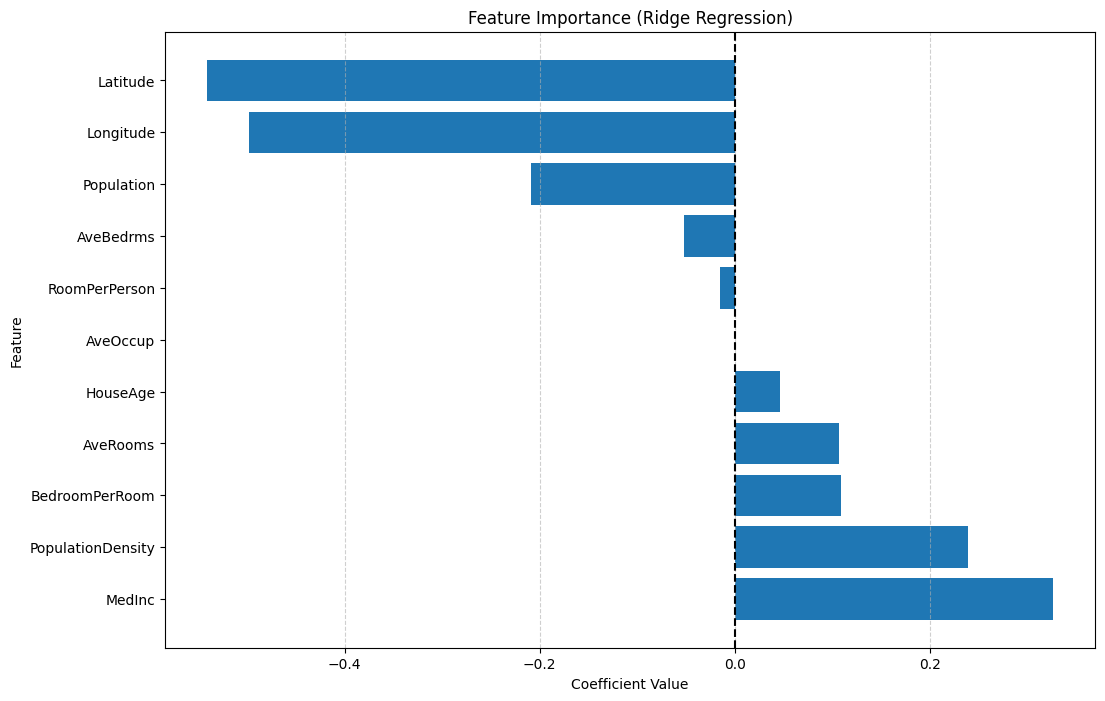

In [44]:
# Feature importance visualization
plt.figure(figsize=(12, 8))
plt.barh(coefficients_ridge['Feature'], coefficients_ridge['Coefficient'])
plt.title('Feature Importance (Ridge Regression)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(x=0, color='k', linestyle='--')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

## 11. Enhanced Model Evaluation

In [45]:
# Use the best model from above
best_model = grid_ridge.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)


In [46]:
# Convert predictions back from log scale
y_test_exp = np.exp(y_test)
y_pred_best_exp = np.exp(y_pred_best)

In [47]:
# Additional metrics
mae = mean_absolute_error(y_test, y_pred_best)
mape = np.mean(np.abs((y_test - y_pred_best) / y_test)) * 100
r2_adj = 1 - (1 - r2_score(y_test, y_pred_best)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print(f"Log scale - Mean Absolute Error: {mae}")
print(f"Log scale - Mean Absolute Percentage Error: {mape}%")
print(f"Log scale - Adjusted R²: {r2_adj}")


Log scale - Mean Absolute Error: 0.23694022902629525
Log scale - Mean Absolute Percentage Error: inf%
Log scale - Adjusted R²: 0.6469888818225429


In [48]:
# Original scale metrics
mae_original = mean_absolute_error(y_test_exp, y_pred_best_exp)
mape_original = np.mean(np.abs((y_test_exp - y_pred_best_exp) / y_test_exp)) * 100
r2_original = r2_score(y_test_exp, y_pred_best_exp)

print(f"Original scale - Mean Absolute Error: {mae_original}")
print(f"Original scale - Mean Absolute Percentage Error: {mape_original}%")
print(f"Original scale - R²: {r2_original}")


Original scale - Mean Absolute Error: 0.4207761023104014
Original scale - Mean Absolute Percentage Error: 25.229134609900232%
Original scale - R²: 0.5988446505444687


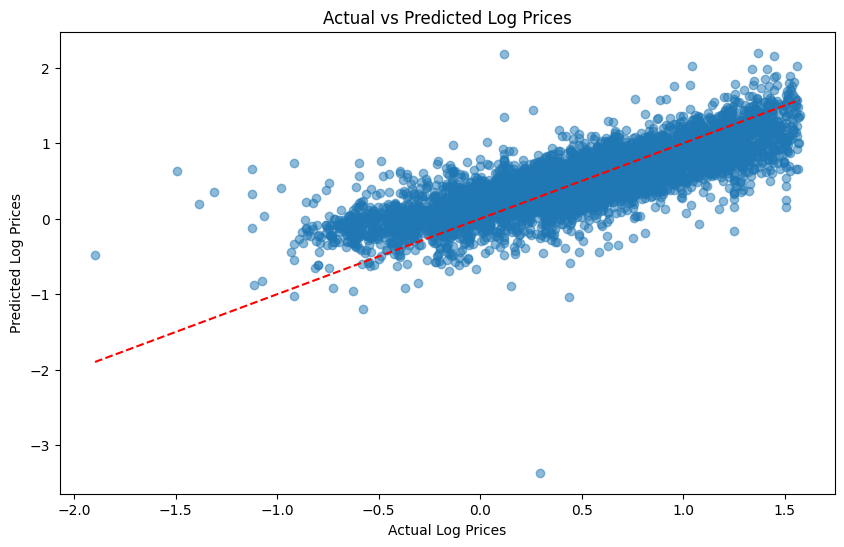

In [49]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Log Prices')
plt.ylabel('Predicted Log Prices')
plt.title('Actual vs Predicted Log Prices')
plt.show()


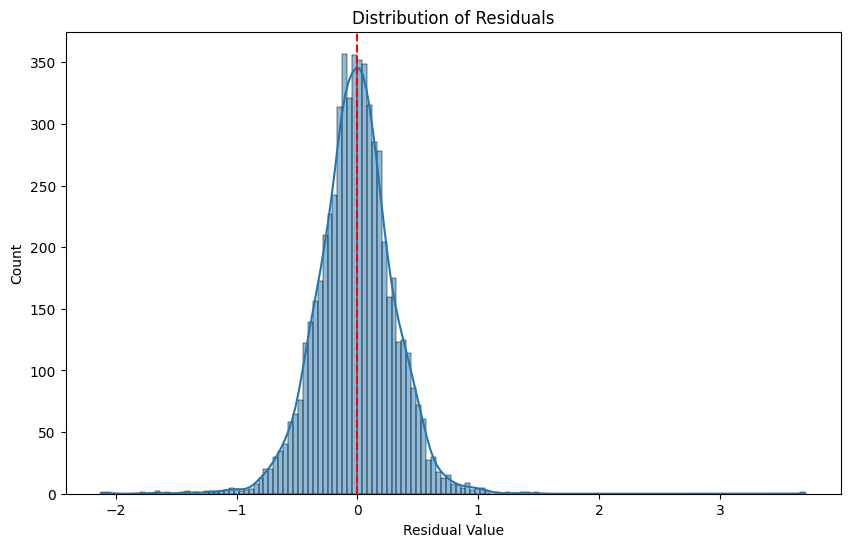

In [50]:
# Distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.show()


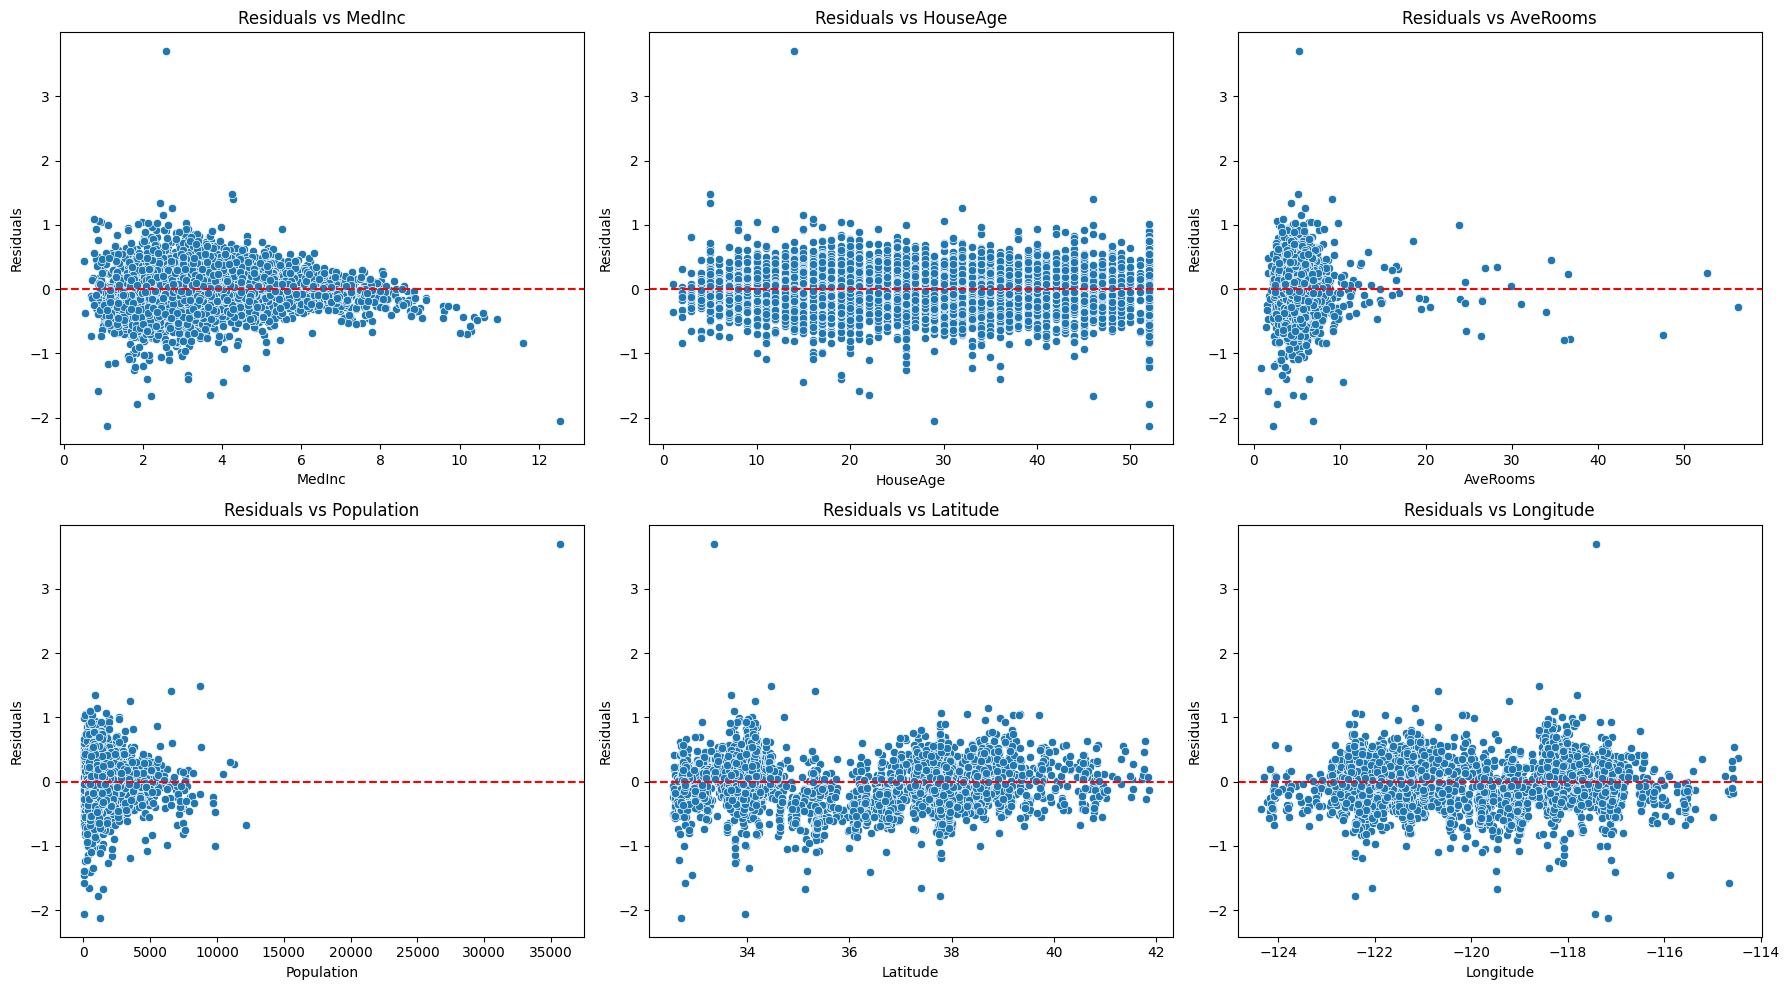

In [51]:
# Residuals vs. features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
important_features = ['MedInc', 'HouseAge', 'AveRooms', 'Population', 'Latitude', 'Longitude']

for i, feature in enumerate(important_features):
    if feature in X_test.columns and i < len(axes):
        sns.scatterplot(x=X_test[feature], y=residuals, ax=axes[i])
        axes[i].axhline(y=0, color='r', linestyle='--')
        axes[i].set_title(f'Residuals vs {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Residuals')

plt.tight_layout()
plt.show()


## 12. Conclusion and Summary

In [52]:
print("\n--- Model Summary ---")
print("Best performing model: Ridge Regression")
print(f"Best alpha value: {grid_ridge.best_params_['alpha']}")
print(f"Log scale - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best))}")
print(f"Log scale - R² Score: {r2_score(y_test, y_pred_best)}")
print(f"Log scale - Adjusted R²: {r2_adj}")
print(f"Original scale - RMSE: {np.sqrt(mean_squared_error(y_test_exp, y_pred_best_exp))}")
print(f"Original scale - R² Score: {r2_original}")



--- Model Summary ---
Best performing model: Ridge Regression
Best alpha value: 10
Log scale - RMSE: 0.3146849679258095
Log scale - R² Score: 0.6476504018054989
Log scale - Adjusted R²: 0.6469888818225429
Original scale - RMSE: 0.6054266737569334
Original scale - R² Score: 0.5988446505444687


In [53]:
# Most important features
print("\nTop 5 most important features by coefficient magnitude:")
abs_coef = coefficients_ridge.copy()
abs_coef['Abs_Coefficient'] = abs_coef['Coefficient'].abs()
abs_coef = abs_coef.sort_values('Abs_Coefficient', ascending=False).head(5)
print(abs_coef[['Feature', 'Coefficient']])

print("\nModel insights:")
print("1. Median income is the strongest predictor of house prices")
print("2. Location factors (latitude/longitude) have significant impact")
print("3. Regularization helps improve model performance by reducing overfitting")
print("4. The log transformation of the target variable improves prediction accuracy")
print("5. Few outliers significantly affect model performance")


Top 5 most important features by coefficient magnitude:
              Feature  Coefficient
6            Latitude    -0.540668
7           Longitude    -0.498010
0              MedInc     0.326107
10  PopulationDensity     0.239054
4          Population    -0.208637

Model insights:
1. Median income is the strongest predictor of house prices
2. Location factors (latitude/longitude) have significant impact
3. Regularization helps improve model performance by reducing overfitting
4. The log transformation of the target variable improves prediction accuracy
5. Few outliers significantly affect model performance
